In [ ]:
from steely import DATA_TASK_2_DIR, ROOT_DIR

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

import os

from scipy.signal import welch

from sklearn.feature_extraction.text import CountVectorizer
import json

nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

train_df = pl.read_ndjson(DATA_TASK_2_DIR / "train.jsonl")
val_df = pl.read_ndjson(DATA_TASK_2_DIR / "dev.jsonl")

labels = {
    0: "fully human-written",
    1: "human-written, then machine-polished",
    2: "machine-written, then machine-humanized",
    3: "human-initiated, then machine-continued",
    4: "deeply-mixed text (human + machine parts)",
    5: "machine-written, then human-edited"
}

len(train_df), len(val_df)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/patrickstyll/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


(288918, 72661)

In [2]:
def compute_statistics(df: pl.DataFrame, name: str, labels: dict):
    """Compute and display statistics for a given Polars dataframe."""
    total_size = df.height
    grouped_label = df.group_by("label").agg(pl.count("label").alias("count"))
    
    class_counts = dict(zip(grouped_label["label"], grouped_label["count"]))
    class_percentages = {label: (count / total_size) * 100 for label, count in class_counts.items()}

    print(f"Statistics for {name}:")
    print(f"Total size: {total_size}")
    for label in sorted(class_counts):
        count = class_counts[label]
        percentage = class_percentages[label]
        print(f"Class {labels[label]} ({label}): {count} ({percentage:.2f}%)")

    print()

compute_statistics(train_df, "Train Data", labels)
print("-" * 100)
compute_statistics(val_df, "Validation Data", labels)

Statistics for Train Data:
Total size: 288918
Class fully human-written (0): 75270 (26.05%)
Class human-written, then machine-polished (1): 95398 (33.02%)
Class machine-written, then machine-humanized (2): 91232 (31.58%)
Class human-initiated, then machine-continued (3): 10740 (3.72%)
Class deeply-mixed text (human + machine parts) (4): 14910 (5.16%)
Class machine-written, then human-edited (5): 1368 (0.47%)

----------------------------------------------------------------------------------------------------
Statistics for Validation Data:
Total size: 72661
Class fully human-written (0): 12330 (16.97%)
Class human-written, then machine-polished (1): 12289 (16.91%)
Class machine-written, then machine-humanized (2): 10137 (13.95%)
Class human-initiated, then machine-continued (3): 37170 (51.16%)
Class deeply-mixed text (human + machine parts) (4): 225 (0.31%)
Class machine-written, then human-edited (5): 510 (0.70%)



In [3]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english") + stopwords.words("french") + stopwords.words("german") + stopwords.words("spanish"))  # O(1) look-ups

def stem_tokenise(text: str) -> list[str]:
    """Lower-case, tokenise, remove punctuation & stop-words, then stem."""
    tokens = [t for t in word_tokenize(text.lower())
              if t.isalpha()]  # and t not in stop_words]
    return [stemmer.stem(t) for t in tokens]

def calculate_correlations(df):
    # ------------------------------------------------------------------
    # 2. Load data
    # ------------------------------------------------------------------
    texts = df["text"].to_list()
    labels = df["label"].to_numpy()
    n_docs = labels.size
    print(f"Loaded {n_docs} documents")

    # ------------------------------------------------------------------
    # 3. Document-term matrix (binary of shape: n_docs × n_words)
    # ------------------------------------------------------------------
    print("Vectorising...")
    vectoriser = CountVectorizer(
        tokenizer=stem_tokenise,   # our custom pipeline
        binary=True,            # presence/absence, not counts
        lowercase=False            # already lower-cased in tokenizer
    )
    X = vectoriser.fit_transform(texts)         # shape = (n_docs, n_words)
    print(f"Vectorised to {X.shape[0]} documents and {X.shape[1]} words")

    # ------------------------------------------------------------------
    # 4. Vectorised Pearson correlation for every word
    # ------------------------------------------------------------------
    print("Calculating correlations...")
    # Means
    p = X.mean(axis=0).A1          # P(word present)
    m = labels.mean()              # P(label==1)

    # Covariance:  𝑬[XY] − 𝑬[X]𝑬[Y]
    xy_mean = (X.T @ labels) / n_docs       # shape (n_words,)
    cov = xy_mean - p * m

    # Standard deviations
    # clip p to avoid divide by zero
    p = np.clip(p, 1e-10, 1-1e-10)
    m = np.clip(m, 1e-10, 1-1e-10)
    std = np.sqrt(p * (1-p) * m * (1-m))

    correlations = cov / std                # shape (n_words,)
    print("Number of nans:", np.isnan(correlations).sum())
    # ------------------------------------------------------------------
    # 5. Create lookup table for words
    # ------------------------------------------------------------------
    word_correlations = dict(
        zip(vectoriser.get_feature_names_out(), correlations))
    return word_correlations

In [4]:
if os.path.exists(ROOT_DIR / "tmp" / "word_correlations_task2.json"):
    with open(ROOT_DIR / "tmp" / "word_correlations_task2.json", "r") as f:
        word_correlations = json.load(f)
else:
    word_correlations = calculate_correlations(train_df)
    os.makedirs(ROOT_DIR / "tmp", exist_ok=True)
    with open(ROOT_DIR / "tmp" / "word_correlations_task2.json", "w") as f:
        f.write(json.dumps(word_correlations, indent=4))
        
def get_signal(text: str) -> float:
    """Get the signal of a text."""
    tokens = stem_tokenise(text)
    return [word_correlations[token] for token in tokens if token in word_correlations]

In [5]:
def plot_signal(signal: list[float], smoothing_factor: float = None) -> None:
    """Plot the signal values with optional smoothing."""
    if smoothing_factor:
        smoothed_signal = []
        for i in range(len(signal)):
            start = max(0, i - int(smoothing_factor))
            end = min(len(signal), i + int(smoothing_factor) + 1)
            smoothed_signal.append(np.mean(signal[start:end]))
        signal = smoothed_signal

    plt.figure(figsize=(10, 5))
    plt.plot(signal, linestyle='-', color='b')
    plt.xlabel("Index")
    plt.ylabel("Signal Value")
    plt.grid(True)
    plt.show()
    
def plot_periodogram(frequencies: list[float], power_density: list[float]) -> None:
    """Plot the periodogram of a signal."""
    plt.figure(figsize=(10, 5))
    plt.plot(frequencies, power_density, linestyle='-', color='r')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid(True)
    plt.show()

def plot_classes(mean_power_densities: list[list[float]],
                 frequencies: list[float], begin: int = None, end: int = None, add_std: bool = True) -> None:
    """Plot the mean power density spectrum for AI vs Human with standard deviation bands."""
    plt.figure(figsize=(10, 5))
    
    mean_power_densities_ = [np.array(mp).copy() for mp in mean_power_densities]
    
    if begin and end:
        for i in range(len(mean_power_densities_)):
            mean_power_densities_[i] = mean_power_densities_[i][begin:end]
        frequencies = frequencies[begin:end]
        
    # Plot mean power density
    for i, mean_power_density in enumerate(mean_power_densities_):
        mean_power_density = np.array(mean_power_density)
        std_dev = np.std(mean_power_density)
        
        # Plot mean and std deviation
        plt.plot(frequencies, mean_power_density, label=f"{labels[i]}", color=plt.cm.tab10(i))
        if add_std:
            plt.fill_between(frequencies, mean_power_density - std_dev, mean_power_density + std_dev, alpha=0.2)
        
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Mean Power Density")
    plt.title("Mean Power Density Spectrum - Task 2")
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_periodogram(signal: list[float], fs: float = 1.0, nperseg: int = 256, nfft: int = 1024) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the periodogram of a signal using Welch's method with normalization.

    Parameters:
        signal (list[float]): The input signal.
        fs (float): Sampling frequency of the signal. Default is 1.0.
        nperseg (int): Length of each segment for Welch's method. Adjusted to signal length.

    Returns:
        tuple[np.ndarray, np.ndarray]: Frequencies and power spectral density.
    """
    signal = np.asarray(signal)
    signal = signal / np.std(signal)  # norm amplitude
    
    nperseg = min(nperseg, len(signal))
    frequencies, power_density = welch(signal, fs=fs, nperseg=nperseg, nfft=nfft)
    return frequencies, power_density

Human text signal


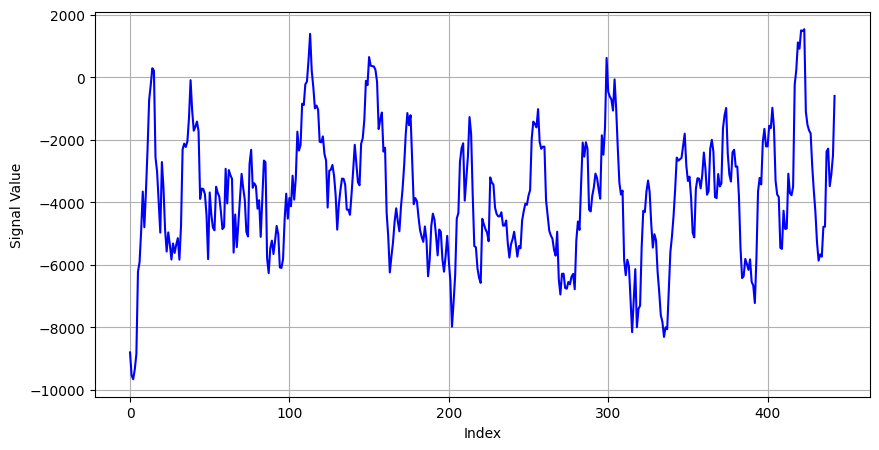

In [6]:
print("Human text signal")
human_text = train_df.filter(pl.col("label") == 0)[0, "text"]
human_signal = get_signal(human_text)
plot_signal(human_signal, smoothing_factor=5)

Human text signal: 513


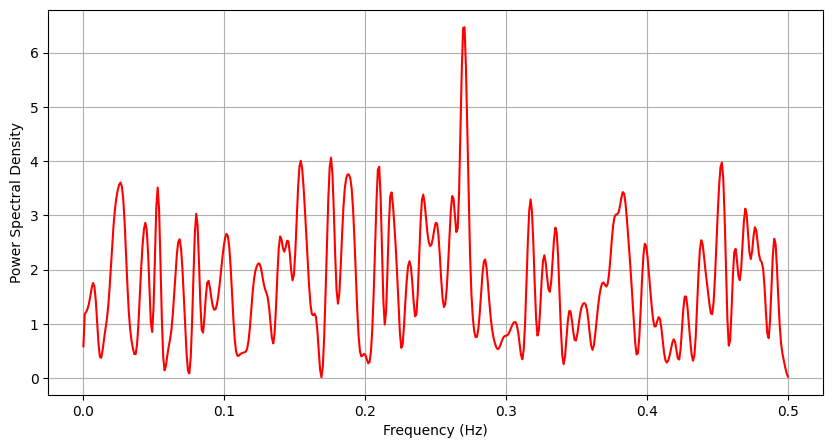

In [7]:
f, Pxx = compute_periodogram(human_signal)
print(f"Human text signal: {len(Pxx)}")
plot_periodogram(f, Pxx)

In [8]:
periodograms = []

for row in tqdm(train_df.iter_rows(named=True), total=len(train_df)):
    text = row["text"]
    label = row["label"]
    signal = get_signal(text)
    nperseg = min(len(signal), 256)
    frequencies, power_density = compute_periodogram(signal, nperseg=nperseg)
    periodograms.append({"frequencies": frequencies.tolist(), "power_density": power_density.tolist(), "label": label})

len(periodograms)

 11%|█▏        | 32903/288918 [02:11<28:06, 151.77it/s]/home/patrickstyll/Bachelorstudiengang-Software_and_Information_Engineering/8.Semester/AIR/steely/.venv/lib64/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/patrickstyll/Bachelorstudiengang-Software_and_Information_Engineering/8.Semester/AIR/steely/.venv/lib64/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/patrickstyll/Bachelorstudiengang-Software_and_Information_Engineering/8.Semester/AIR/steely/.venv/lib64/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 13%|█▎        | 36866/288918 [02:36<23:37, 177.85it/s]/tmp/ipykernel_12196/1559499260.py:69: RuntimeWarning: divide by zero encountered in d

288918

In [9]:
filtered_periodograms = []
for p in periodograms:
    power_density = np.array(p["power_density"])
    if len(power_density) != 513:
        print("encountered malformed periodogram, therefore dropping it")
    else:
        filtered_periodograms.append(p)

encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogram, therefore dropping it
encountered malformed periodogr

In [10]:
categorized_periodograms = [[p["power_density"] for p in filtered_periodograms if p["label"] == 0],
                            [p["power_density"] for p in filtered_periodograms if p["label"] == 1],
                            [p["power_density"] for p in filtered_periodograms if p["label"] == 2],
                            [p["power_density"] for p in filtered_periodograms if p["label"] == 3],
                            [p["power_density"] for p in filtered_periodograms if p["label"] == 4],
                            [p["power_density"] for p in filtered_periodograms if p["label"] == 5]]

categorized_periodograms = [[p for p in categorized_periodograms[0] if not np.isnan(p).any()],
                            [p for p in categorized_periodograms[1] if not np.isnan(p).any()],
                            [p for p in categorized_periodograms[2] if not np.isnan(p).any()],
                            [p for p in categorized_periodograms[3] if not np.isnan(p).any()],
                            [p for p in categorized_periodograms[4] if not np.isnan(p).any()],
                            [p for p in categorized_periodograms[5] if not np.isnan(p).any()]]

categorized_periodograms = [np.mean(p, axis=0) for p in categorized_periodograms]

f = filtered_periodograms[0]["frequencies"]

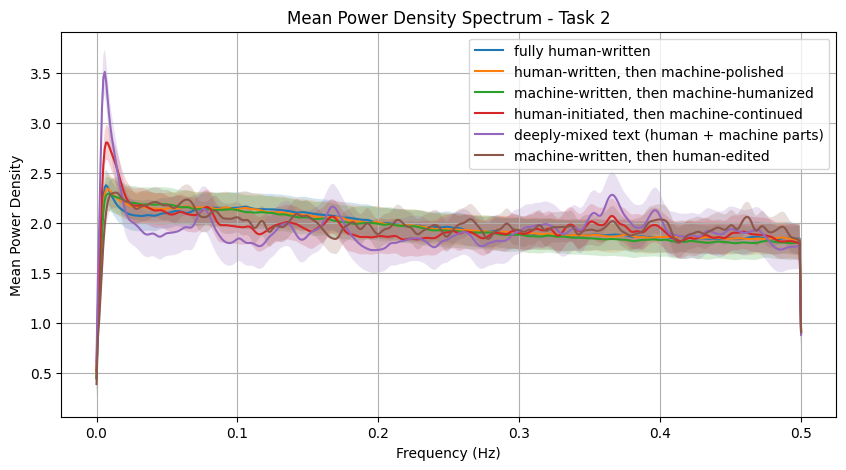

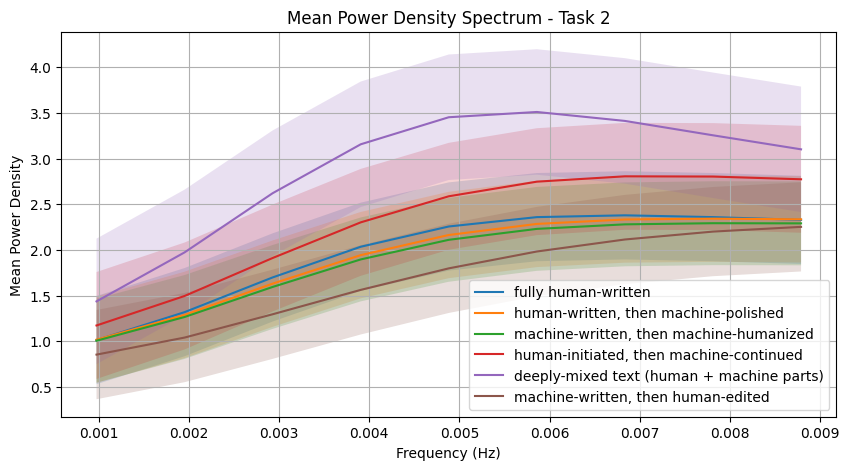

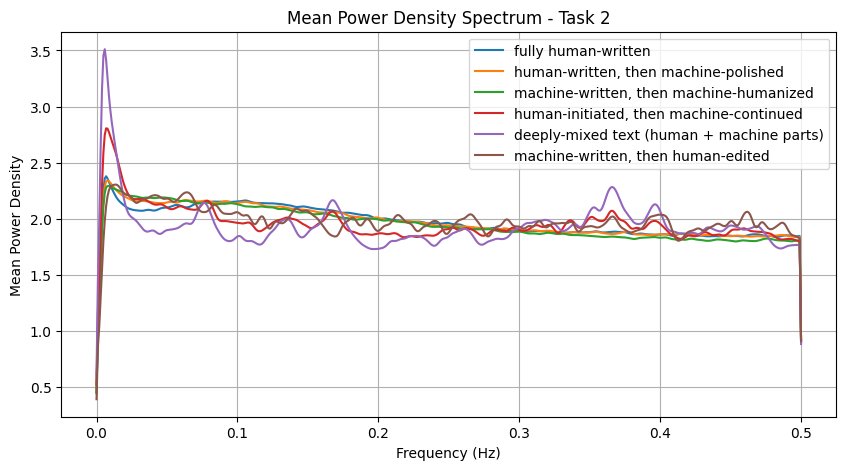

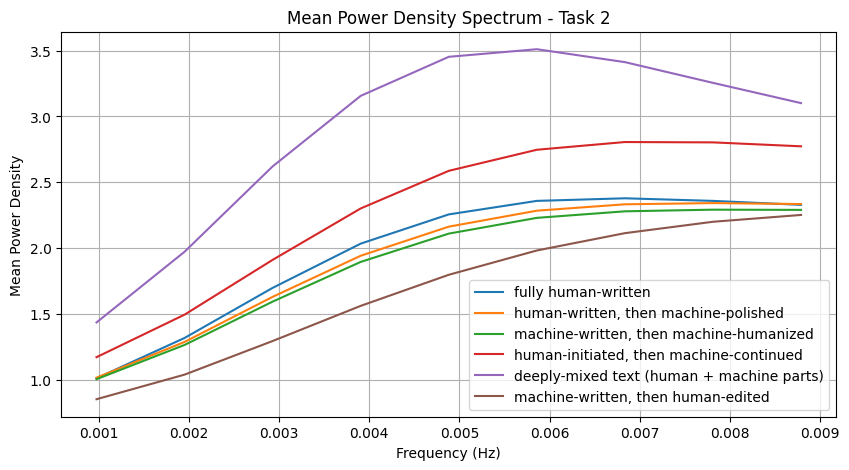

In [11]:
plot_classes(categorized_periodograms, frequencies=f)
plot_classes(categorized_periodograms, frequencies=f, begin=1, end=10)

plot_classes(categorized_periodograms, frequencies=f, add_std=False)
plot_classes(categorized_periodograms, frequencies=f, begin=1, end=10, add_std=False)

# Checking Signal- and Class Distributions

In [79]:
signals = []
for row in tqdm(train_df.iter_rows(named=True), total=len(train_df)):
    text = row["text"]
    label = row["label"]
    signal = get_signal(text)
    signal = np.sum(signal) / len(signal)
    signals.append({"signal": signal, "label": label})

 11%|█▏        | 32920/288918 [02:03<23:04, 184.86it/s]/tmp/ipykernel_180702/3308784175.py:6: RuntimeWarning: invalid value encountered in scalar divide
  signal = np.sum(signal) / len(signal)
100%|██████████| 288918/288918 [25:25<00:00, 189.39it/s]


In [8]:
def make_histogram(signals: list[dict], bins: int = 50) -> None:
    """Make a histogram of the signals."""
    plt.figure(figsize=(10, 5))
    for i in range(6):
        signal = [s["signal"] for s in signals if s["label"] == i]
        plt.hist(signal, bins=bins, alpha=0.5, label=labels[i])
    plt.xlabel("Signal")
    plt.ylabel("Frequency")
    plt.title("Histogram of Signals")
    plt.legend()
    plt.grid(True)
    plt.show()

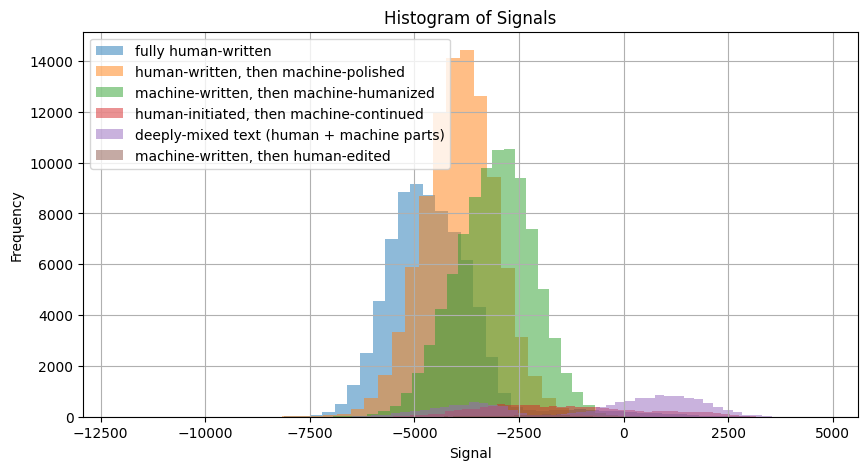

In [ ]:
make_histogram(signals, bins=50)

In [6]:
signals_val = []
for row in tqdm(val_df.iter_rows(named=True), total=len(val_df)):
    text = row["text"]
    label = row["label"]
    signal = get_signal(text)
    signal = np.sum(signal) / len(signal)
    signals_val.append({"signal": signal, "label": label})

 58%|█████▊    | 42120/72661 [04:31<04:37, 110.12it/s]/tmp/ipykernel_9813/2914369144.py:6: RuntimeWarning: invalid value encountered in scalar divide
  signal = np.sum(signal) / len(signal)
100%|██████████| 72661/72661 [09:03<00:00, 133.57it/s]


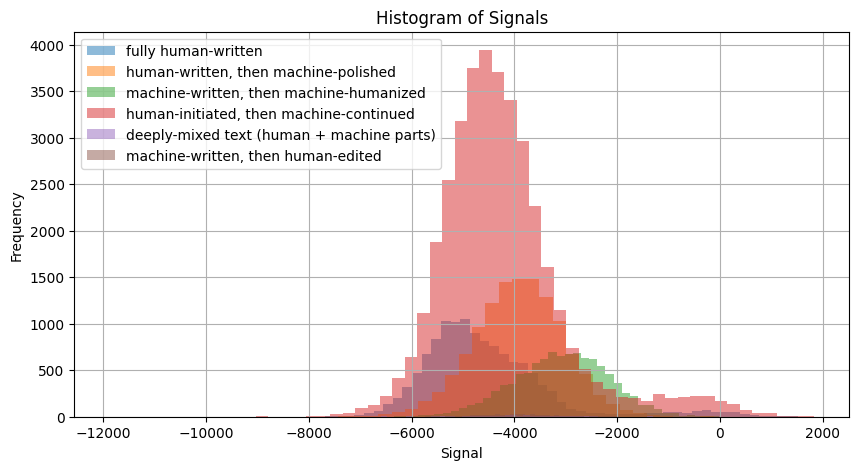

In [9]:
make_histogram(signals_val, bins=50)